In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [6]:
# Query All Records in the the station Table
station_data = pd.read_sql("SELECT * FROM station", conn)
station_data

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [7]:
# Query All Records in the the measurement Table
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
measurement_data

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [8]:
# Print all of the classes mapped to the Base

Base.classes.keys()

['measurement', 'station']

In [9]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

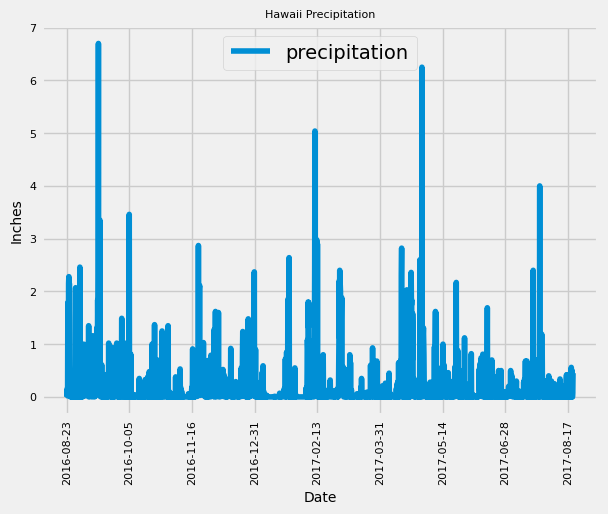

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
one_year = dt.date(2017,8,23)-dt.timedelta(days=365)

# Calculate the date one year from the last date in data set.
last__date_year_data = dt.date(one_year.year, one_year.month, one_year.day)

# Perform a query to retrieve the data and precipitation scores
data_score = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=last__date_year_data).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_df = pd.DataFrame(data_score,columns=['date','precipitation'])

# Sort the dataframe by date
data_df.set_index(data_df['date'],inplace=True)

#drop N/A cells
clean_data_df = data_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
clean_data_df.plot('date','precipitation')
plt.xlabel("Date",  size = 10)
plt.ylabel("Inches", size = 10)
plt.title('Hawaii Precipitation' , size = 8)
plt.legend(["precipitation"],loc='upper center')
plt.xticks(rotation=90, size = 8)
plt.yticks(size = 8)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
clean_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

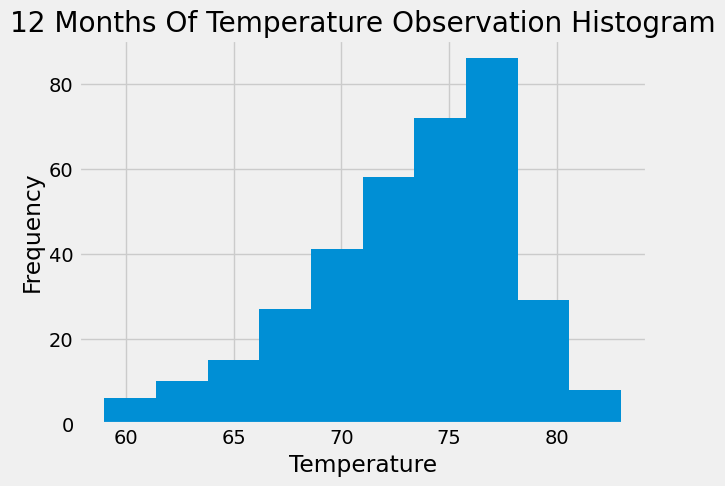

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result= session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').all()

temp = pd.DataFrame(result,columns=['tobs'])
temp.hist(bins=10)
plt.tight_layout()
plt.title('12 Months Of Temperature Observation Histogram')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()


# Close Session

In [18]:
# Close Session
session.close()
